In [25]:
import gymnasium as gym
import gym_donkeycar

import os
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Categorical

import torchvision
from torchvision import transforms

# custom classes and functions
import models
from models.blocks import ConvBlock, TransposeConvBlock, ResConvBlock, CategoricalStraightThrough
from models.autoencoder import Autoencoder
from models.vae import VAE
from models.categorical_vae import CategoricalVAE
from preprocessing import grayscale_transform as transform

%matplotlib inline

In [7]:
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Create VAE

In [29]:
batch_size = 8

# VAE
vae = CategoricalVAE(
    greyscale=True,
    vae_ent_coeff=0.000001
).to(device)

# VAE optimizer
vae_optim = optim.Adam(
    vae.parameters(), 
    lr=1e-3,
    weight_decay=1e-5 # l2 regularization
)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

# display VAE stats
vae.info()

| CategoricalVAE info |
-----------------------
device: cuda
number of parameters: 38_151_857
input shape : [8, 1, 128, 128]
hidden shape: [8, 32, 32]
output shape: [8, 1, 128, 128]


## Training loop

In [24]:
""" vae training loop """

# create the environment
toy_env = False

if toy_env:
    env = gym.make("CarRacing-v2", render_mode="rgb_array")
else:
    exe_path = "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64"
    port = 9091
    config = {
        "exe_path" : exe_path, 
        "port" : port 
    }
    env = gym.make(
        "GymV21Environment-v0", 
        env_id="donkey-minimonaco-track-v0", # donkey-warehouse-v0 
        make_kwargs={
            "conf": config
        })

verbose = True
n_episodes = 10000
vae_losses, reconstruction_losses, entropy_losses = [], [], []
vae.train()

for episode in tqdm(range(n_episodes)):
    
    # get the initial state
    obs, info = env.reset()
    
    # setup a minibatch of x's for training the autoencoder
    batch_counter = 0
    x = transform(obs)
    batch_tensor = torch.empty((batch_size,) + x.shape, device=device) # B,C,H,W
    
    # play one episode
    done = False
    while not done:
             
        # add the new x to the batch
        batch_tensor[batch_counter] = transform(obs)
        batch_counter += 1
        
        if batch_counter % batch_size == 0:
            # reset the batch counter
            batch_counter = 0
            
            # autoencoder forward pass with a minibatch
            xhat = vae(batch_tensor)

            # get a loss and update the autoencoder
            vae_loss, reconstruction_loss, weighted_entropy_loss = vae.get_loss(batch_tensor, xhat)
            vae_optim.zero_grad()
            vae_loss.backward()
            vae_optim.step()
            
            vae_losses.append(vae_loss.item())
            reconstruction_losses.append(reconstruction_loss.item())
            entropy_losses.append(weighted_entropy_loss.item())
            
        # choose and execute an action
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, info = env.step(action)        
               
        done = terminated or truncated
        obs = next_obs
    
    if verbose and episode % 20 == 0: 
        print(f"train episode [{episode}/{n_episodes}] ===> Loss: {vae_loss.item():.3f}, ReconstructionLoss: {reconstruction_loss.item():.3f}, weighted_entropy_loss: {weighted_entropy_loss.item():.3f}, lr: {get_lr(vae_optim)}")
        
env.close()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: max_cte 8.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: host localhost
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
donkey subprocess started
Found path: /home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64


INFO:gym_donkeycar.core.client:connecting to localhost:9091 


loading scene mini_monaco


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


closing donkey sim subprocess


  0%|                                                                                      | 1/10000 [00:03<10:07:24,  3.64s/it]

train episode [0/10000] ===> Loss: 0.953, ReconstructionLoss: 0.953, weighted_entropy_loss: -0.000, lr: 0.01


  0%|                                                                                      | 6/10000 [00:22<10:15:00,  3.69s/it]


KeyboardInterrupt: 

## Plot results

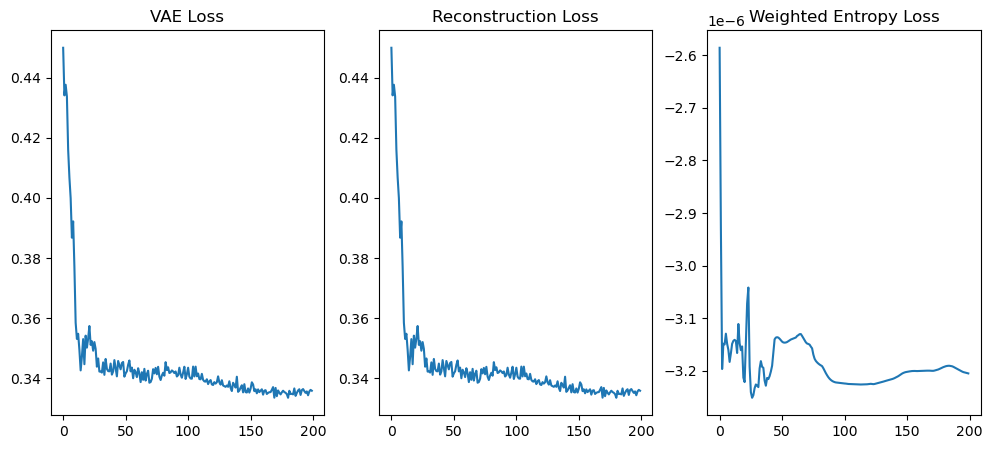

In [17]:
rolling_length = 1

fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("VAE Loss")
vae_losses_moving_average = (
    np.convolve(
        np.array(vae_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(vae_losses_moving_average)), vae_losses_moving_average)


axs[1].set_title("Reconstruction Loss")
reconstruction_losses_moving_average = (
    np.convolve(
        np.array(reconstruction_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[1].plot(range(len(reconstruction_losses_moving_average)), reconstruction_losses_moving_average)

axs[2].set_title("Weighted Entropy Loss")
entropy_losses_moving_average = (
    np.convolve(
        np.array(entropy_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[2].plot(range(len(entropy_losses_moving_average)), entropy_losses_moving_average);

# Overfitting and visualization playground

In [ ]:
""" overfit to one sample """
batch_tensor = torch.load("batch_tensor.pt").to(device)
vae_losses, reconstruction_losses, entropy_losses = [], [], []

for i in range(200):
    
    xhat = vae(batch_tensor)

    # get a loss and update the autoencoder
    vae_loss, reconstruction_loss, entropy_loss = vae.get_loss(batch_tensor, xhat)
    vae_optim.zero_grad()
    vae_loss.backward()
    vae_optim.step()

    vae_losses.append(vae_loss.item())
    reconstruction_losses.append(reconstruction_loss.item())
    entropy_losses.append(entropy_loss.item())

    if i % 20 == 0:
        print(f"[{i+1}/{200}] loss: {vae_loss.item()}, entropy loss: {entropy_loss}, lr: {get_lr(vae_optim)}")

In [ ]:
batch_tensor = torch.load("batch_tensor.pt").to(device)

""" show the observation """
plt.imshow(torch.permute(batch_tensor[0].cpu(), (1,2,0)), cmap="gray")
plt.show()

""" show the reconstruction """
vae.eval()
with torch.no_grad():
    xhat = vae(batch_tensor)
    plt.imshow(torch.permute(xhat[0].cpu(), (1,2,0)), cmap="gray")
    plt.show()
vae.train();